這邊我會假設你已經看過所有YOLOv3的系列文章，並且也瞭解前面幾個部份的說明

下面先給出眾多的參考資料，瞭解一個架構不容易，參考的自然也多了，正確的寫出引用、參照是學習過程中的必要：

* [YOLO: Real-Time Object Detection](https://pjreddie.com/darknet/yolo/)
* [pjreddie/darknet](https://github.com/pjreddie/darknet)
* [YOLOv3_論文翻譯連結](https://hackmd.io/@shaoeChen/SyjI6W2zB/https%3A%2F%2Fhackmd.io%2F%40shaoeChen%2FryHg904h9)
* [YOLOv3深度解析](https://blog.csdn.net/leviopku/article/details/82660381)
* [qqwweee/keras-yolo3](https://github.com/qqwweee/keras-yolo3)
* [YunYang1994/tensorflow-yolov3](https://github.com/YunYang1994/tensorflow-yolov3)
* [joymyhome_Yolov3 config file中pad的理解](https://blog.csdn.net/joymyhome/article/details/106349084)
* [華為雲開發者社區](https://segmentfault.com/a/1190000039009074)
* [pylessons_YOLOv3-TF2-mnist](https://pylessons.com/YOLOv3-TF2-mnist)

我的docker上執行的版本為tensorflow 2.1，雖然現在流行人生苦短我用PyTorch，不過我還是先繼續tf + keras。

In [703]:
import tensorflow as tf
tf.__version__

'2.1.0'

指定使用的gpu

In [704]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
tf.config.experimental.set_visible_devices(devices=gpus[0], device_type='GPU')

In [705]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

我們已經看起來成功訓練一個模型了，只是看起來，輸贏要現在才能知道，所以我們就要先來載入模型。

In [706]:
model = tf.saved_model.load('model/16')

如果你的做法是保存權重然後再載入權重的話，那就要先把模型架構做出來，再把權重載入。

就先拿訓練資料抽個幾筆來測試看看

In [707]:
import os
from yolo_utility import get_training_data, plot_dataset, generate_data_for_loss
import matplotlib.patches as patches
import matplotlib.pyplot as plt

%matplotlib inline

一次生成一筆就夠了

In [708]:
%%time
datasets = get_training_data(1)

(9963, 42, 5)
CPU times: user 3.68 s, sys: 122 ms, total: 3.8 s
Wall time: 3.8 s


In [709]:
VOC_NAME_LABEL_CLASS = {
    'none': (0, 'Background'),
    'aeroplane': (1, 'Vehicle'),
    'bicycle': (2, 'Vehicle'),
    'bird': (3, 'Animal'),
    'boat': (4, 'Vehicle'),
    'bottle': (5, 'Indoor'),
    'bus': (6, 'Vehicle'),
    'car': (7, 'Vehicle'),
    'cat': (8, 'Animal'),
    'chair': (9, 'Indoor'),
    'cow': (10, 'Animal'),
    'diningtable': (11, 'Indoor'),
    'dog': (12, 'Animal'),
    'horse': (13, 'Animal'),
    'motorbike': (14, 'Vehicle'),
    'person': (15, 'Person'),
    'pottedplant': (16, 'Indoor'),
    'sheep': (17, 'Animal'),
    'sofa': (18, 'Indoor'),
    'train': (19, 'Vehicle'),
    'tvmonitor': (20, 'Indoor'),
}

VOC_NAME_LABEL = {key:v[0] for key,v in VOC_NAME_LABEL_CLASS.items()}
VOC_LABEL_NAME = {v[0]:key for key,v in VOC_NAME_LABEL_CLASS.items()}

取一筆資料來做測試

In [710]:
img = None
objects = None
for data in datasets.take(1):
    img = data[0]
    objects = (data[1][0]).numpy()

x= 94.90000247955322, y= 93.50458431243896, w= 214.4999876022339, h= 314.86238384246826, label= horse
x= 149.5, y= 36.256879568099976, w= 83.19999504089355, h= 236.62385392189026, label= person


<Figure size 1152x648 with 0 Axes>

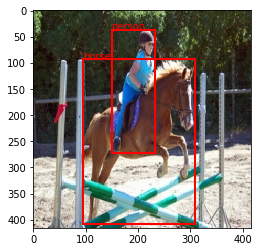

In [711]:
fig = plt.figure(figsize=(16, 9))
f, ax = plt.subplots(1, 1)
ax.imshow(img[0])
# 一張照片上可能有多個物件，因此要迴圈處理    
for idx in range(objects.shape[0]):
    obj = objects[idx]
    if obj[-1] == 0.:
        # 沒物件的時候就直接中斷迴圈
        break        
    # tensor to numpy

    _x = obj[0] * 416
    _y = obj[1] * 416
    _w = (obj[2] * 416) - (obj[0] * 416)
    _h = (obj[3] * 416) - (obj[1] * 416)
    _label = obj[4]

    # 畫方框
    rect = patches.Rectangle((_x, _y), 
                             _w, 
                             _h, 
                             linewidth=2, 
                             facecolor='none', 
                             edgecolor='red')                
    ax.add_patch(rect)
    ax.text(x=_x, y=_y, s=VOC_LABEL_NAME[_label], color='red')    
    print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}, label= {VOC_LABEL_NAME[_label]}')        

plt.show()

上面是我們拿來測試的照片，那一樣是從訓練集中取出的照片，當然還是可以從測試集，只是有很多小細節可能還沒有處理好，所以先求有再求好。

In [712]:
model_output = model(img)
model_output[0].shape, model_output[1].shape, model_output[2].shape, model_output[3].shape, model_output[4].shape, model_output[5].shape

(TensorShape([1, 52, 52, 78]),
 TensorShape([1, 52, 52, 3, 26]),
 TensorShape([1, 26, 26, 78]),
 TensorShape([1, 26, 26, 3, 26]),
 TensorShape([1, 13, 13, 78]),
 TensorShape([1, 13, 13, 3, 26]))

我們的模型輸出根據之前的定義就是raw、decoder的組合，這個decoder之後的結果就是跟我們說，這52x52、26x26、13x13的grid cell的裡面的3個anchor box各有什麼資料，我們沒有那個美國時間慢慢處理三個尺度的資訊，最好的辦法就是跟菲姐一樣，通通喇在一起。

我們只需要decoder之後的資訊，其它的不需要，就送人了

In [713]:
all_anchors = [tf.reshape(x, (-1, tf.shape(x)[-1])) for i, x in enumerate(model_output) if i % 2 == 1]

In [714]:
all_anchors

[<tf.Tensor: shape=(8112, 26), dtype=float32, numpy=
 array([[1.63893712e+00, 6.09763622e+00, 1.13610687e+02, ...,
         1.96974172e-04, 1.92112435e-04, 1.85236335e-04],
        [2.67928481e+00, 6.36065245e+00, 1.90244720e+02, ...,
         4.48121609e-05, 1.20089175e-02, 9.09691229e-02],
        [4.52775151e-01, 7.48241234e+00, 1.56632294e+02, ...,
         2.41442528e-02, 8.24516714e-02, 1.08537219e-01],
        ...,
        [4.09381775e+02, 4.14336304e+02, 1.85432571e+02, ...,
         9.09765458e-06, 9.17126363e-06, 9.30570059e-06],
        [4.11845581e+02, 4.14010681e+02, 3.79793182e+02, ...,
         1.33841627e-06, 2.10077129e-03, 3.66820432e-02],
        [4.08158295e+02, 4.15839630e+02, 2.22628845e+02, ...,
         7.97946751e-03, 2.02990044e-02, 4.78506349e-02]], dtype=float32)>,
 <tf.Tensor: shape=(2028, 26), dtype=float32, numpy=
 array([[1.3485817e+01, 3.7103148e+00, 8.0344146e+03, ..., 1.3954803e-26,
         2.0332333e-11, 7.5814497e-01],
        [1.5894023e+01, 8.172

然後再把上面的list弄成一個很大的np array，從維度不難知道，一張照片產生10647個框來檢核。處理之前我們會先將資料格式轉成numpy。

In [715]:
import numpy as np

In [716]:
all_anchors = tf.concat(all_anchors, axis=0)
all_anchors.shape

TensorShape([10647, 26])

從這一陀框中取得需求的資訊，各別為位置資訊、置信度、類別機率

In [717]:
all_anchors = np.array(all_anchors)

anchors_xywh = all_anchors[:, 0: 4]
anchors_conf = all_anchors[:, 4]
anchors_prob = all_anchors[:, 5:]

anchors_xywh.shape, anchors_conf.shape, anchors_prob.shape

((10647, 4), (10647,), (10647, 21))

先將xywh轉成兩點座標，這邊我有一些細節沒有考慮到的就是，我是以input shape，也就是416x416來處理，所以我就沒有再做縮放，但你實際的input shape可能不會是416x416，那就需要記得再做個縮放。

In [718]:
anchors_lxlyrxry = np.concatenate([anchors_xywh[:, :2] - anchors_xywh[:, 2:] * 0.5,
                                   anchors_xywh[:, :2] + anchors_xywh[:, 2:] * 0.5], axis=-1)
anchors_lxlyrxry.shape

(10647, 4)

從資料來看不難明白，有些座標是超過範圍的，我們的範圍應該就是0~416，所以這邊要做特別的處理

In [719]:
anchors_lxlyrxry[0]

array([-55.166405, -55.029728,  58.444283,  67.225   ], dtype=float32)

In [720]:
anchors_lxlyrxry = np.concatenate([np.maximum(anchors_lxlyrxry[:, :2], [0, 0]),
                                   np.minimum(anchors_lxlyrxry[:, 2:], [416 - 1, 416 - 1])], axis=-1)

anchors_lxlyrxry[0]

array([ 0.        ,  0.        , 58.44428253, 67.22499847])

另外就是，我們的座標是左上x、左上y、右下x、右下y，這意味著，左上x一定小於右下x，左上y一定小於右下y。如果有發生相反的情況，那這個預測本身是無效的。

In [721]:
fail_mask = np.logical_or((anchors_lxlyrxry[:, 0] > anchors_lxlyrxry[:, 2]), (anchors_lxlyrxry[:, 1] > anchors_lxlyrxry[:, 3]))
anchors_lxlyrxry[fail_mask] = 0

接下來就是利用面積開根號做一個排除，相關說明可見最後的附錄

In [722]:
valid_scale = [0, np.inf]

In [723]:
bboxes_scale = np.sqrt(np.multiply.reduce(anchors_lxlyrxry[:, 2:4] - anchors_lxlyrxry[:, 0:2], axis=-1))
scale_mask = np.logical_and((valid_scale[0] < bboxes_scale), (bboxes_scale < valid_scale[1]))

In [724]:
np.where(scale_mask==False, 1, 0).sum()

0

最後要排除掉置信度低於閥值的框

In [725]:
# 取得類別機率最高的類別索引
classes = np.argmax(anchors_prob, axis=-1)
classes.shape

(10647,)

取得每一個box機率最高那個類別索引的機率值

In [726]:
anchors_prob[np.arange(len(anchors_lxlyrxry)), classes]

array([3.9585486e-01, 5.6655812e-01, 4.6825299e-01, ..., 6.7088404e-03,
       9.9913675e-01, 8.3029709e-06], dtype=float32)

In [727]:
anchors_prob[np.arange(len(anchors_lxlyrxry)), classes].shape

(10647,)

然後把機率值跟置信度相乘

In [728]:
scores = anchors_conf * anchors_prob[np.arange(len(anchors_lxlyrxry)), classes]
scores.shape

(10647,)

做個遮罩，0.1是我亂給的閥值，因為超過0.1之後滿足條件的是0...

In [729]:
score_mask = scores > 0.3
np.where(score_mask==True, 1, 0).sum()

6

把這個遮罩跟上面的遮罩做個and

In [730]:
mask = np.logical_and(scale_mask, score_mask)
np.where(mask==True, 1, 0).sum()

6

最後就得到了最終結果

In [731]:
lxlyrxry, scores, classes = anchors_lxlyrxry[mask], scores[mask], classes[mask]
lxlyrxry.shape, scores.shape, classes.shape

((6, 4), (6,), (6,))

把這三個陣列堆起來，不難明白後面兩個要推一個軸出去

In [732]:
final_result = np.concatenate([lxlyrxry, scores[:, np.newaxis], classes[:, np.newaxis]], axis=-1)
final_result.shape

(6, 6)

整個過程可以發現到我一直在注意維度，因為維度真的很重要，一定要確定好。

還沒有結束，我們只是先做一個框的排除，很明顯的，在排除之後還有9個框，但上面不難發現，照片就一個框，這肯定有毛才會有九個框，可以先畫出來看看。

這時候我們整理出資料維度是boxes_num x 6，分別為左上x、左上y、右下x、右下y、置信度、類別

x= 93.00779724121094, y= 37.972412109375, w= 165.98439025878906, h= 340.05517578125, label= 15.0, conf=0.3689004182815552
x= 78.8045883178711, y= 40.757965087890625, w= 194.39081573486328, h= 334.48406982421875, label= 15.0, conf=0.30278146266937256
x= 90.13423156738281, y= 37.78692626953125, w= 139.73153686523438, h= 244.4261474609375, label= 15.0, conf=0.6007974743843079
x= 40.880462646484375, y= 14.693954467773438, w= 302.23907470703125, h= 354.61207580566406, label= 15.0, conf=0.5527330040931702
x= 150.4299774169922, y= 0.0, w= 147.14002990722656, h= 415.0, label= 15.0, conf=0.3156881630420685
x= 104.61760711669922, y= 85.52272033691406, w= 238.76477813720703, h= 276.95457458496094, label= 13.0, conf=0.738071084022522


<Figure size 1152x648 with 0 Axes>

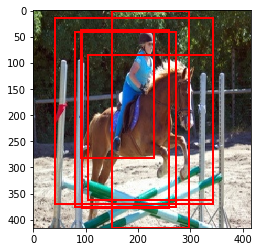

In [733]:
fig = plt.figure(figsize=(16, 9))
f, ax = plt.subplots(1, 1)
ax.imshow(img[0])
# 一張照片上可能有多個物件，因此要迴圈處理    
for idx in range(len(final_result)):
    obj = final_result[idx]
    
    _x = obj[0]
    _y = obj[1]
    _w = (obj[2]) - (obj[0])
    _h = (obj[3]) - (obj[1])


    # 畫方框
    rect = patches.Rectangle((_x, _y), 
                             _w, 
                             _h, 
                             linewidth=2, 
                             facecolor='none', 
                             edgecolor='red')                
    ax.add_patch(rect)
#     ax.text(x=_x, y=_y, color='red')    
    print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}, label= {obj[5]}, conf={obj[4]}')        

plt.show()

清單來看，框到的東西很多都是重覆的，這代表某一個物件是被重覆框到的，每個人都說波多是他的女友，但其實只是他們在夢遊，我們必需排除這種問題，這時候採用的作法就是[Non-max suppression](https://hackmd.io/@shaoeChen/HJUZTKMZz/https%3A%2F%2Fhackmd.io%2Fs%2FSJXmp66KG#3-7Non-max-suppression)。

上面連結的是吳恩達老師課程上的說明，所以很明顯的，不同類別的物件會各自去實現NMS

因為過程中會計算到iou，所以我們先弄個簡單函數

In [734]:
def get_iou(boxes1, boxes2):
    boxes1 = tf.concat([tf.minimum(boxes1[..., :2], boxes1[..., 2:]),
                        tf.maximum(boxes1[..., :2], boxes1[..., 2:])], axis=-1)
    boxes2 = tf.concat([tf.minimum(boxes2[..., :2], boxes2[..., 2:]),
                        tf.maximum(boxes2[..., :2], boxes2[..., 2:])], axis=-1)
    
    boxes1_area = (boxes1[..., 2] - boxes1[..., 0]) * (boxes1[..., 3] - boxes1[..., 1])
    boxes2_area = (boxes2[..., 2] - boxes2[..., 0]) * (boxes2[..., 3] - boxes2[..., 1])
    
    # 準備做交集面積的計算
    # 交集面積點座標，左上取大、右下取小    
    left_up = tf.maximum(boxes1[..., :2], boxes2[..., :2])
    right_down = tf.minimum(boxes1[..., 2:], boxes2[..., 2:])
    
    # 計算交集面積的長寬
    inter_section = tf.maximum(right_down - left_up, 0.0)
    # 計算交集面積
    inter_area = inter_section[..., 0] * inter_section[..., 1]
    # 計算聯集面積
    union_area = boxes1_area + boxes2_area - inter_area
    
    iou = 1.0 * inter_area / union_area
    return iou

首先我們確認類別數，這可以利用set的特性來做重覆值的排除

In [735]:
# 分解動作：取得所有照片內的所有類別
classes_in_img = list(set(final_result[:, 5]))
classes_in_img

[13.0, 15.0]

In [736]:
best_bboxes = []
i = 0
for cls in classes_in_img:    
    # 做一個遮罩，多個類別，我們依各類別來處理
    cls_mask = (final_result[:, 5] ==  cls)    
    # 遮罩蓋上去就是剩下是那個類別的資料
    cls_bboxes = final_result[cls_mask]    
    while len(cls_bboxes) > 0:
        i += 1
        # 先取得機率最高的那一個類別的索引
        max_prob_ind = np.argmax(cls_bboxes[:, 4])        
        # 利用索引取得資料
        best_bbox = cls_bboxes[max_prob_ind]
        # 寫入
        best_bboxes.append(best_bbox)
        # 因為最佳的已經取出了，所以利用堆疊的方式把它排除
        # 上面為例，這時候的cls_bboxes就剩三筆資料
        cls_bboxes = np.concatenate([cls_bboxes[: max_prob_ind], cls_bboxes[max_prob_ind + 1:]])
        # 然後我們就計算這筆最佳的跟其它剩下的框之間的iou
        iou = get_iou(best_bbox[np.newaxis, : 4], cls_bboxes[:, : 4])
#         print(f'iou: {iou}')
        # 設置權重
        weight = np.ones((len(iou), ), dtype=np.float32)
        # 做一個遮罩，0.2的部份是一個閥值，可以以參數設置
        # 這麼做的用意在於說，我們已經先拿一個最高機率的框出來了
        # 跟這個機率最高的框還有iou的話，你肯定是有毛的
        # 所以，只要你們之間的iou太高，那就代表你們兩個有一定的機率是框到同一個東西
        # 跟我鬥，你洗洗睡，所以只要高過閥值的那個就歸零，自然就排除掉兩個框到同一個的問題
        iou_mask = (iou > 0.1).numpy()
        # 超過閥值的權重就歸零
        weight[iou_mask] = 0.0
        # 權重再乘上原始的置信度
        cls_bboxes[:, 4] = cls_bboxes[:, 4] * weight
        # 權重大於0的遮罩
        score_mask = cls_bboxes[:, 4] > 0.
        cls_bboxes = cls_bboxes[score_mask]
        
       

In [737]:
best_bboxes

[array([104.61760712,  85.52272034, 343.38238525, 362.47729492,
          0.73807108,  13.        ]),
 array([ 90.13423157,  37.78692627, 229.86576843, 282.21307373,
          0.60079747,  15.        ])]

x= 104.61760711669922, y= 85.52272033691406, w= 238.76477813720703, h= 276.95457458496094, label=horse
x= 90.13423156738281, y= 37.78692626953125, w= 139.73153686523438, h= 244.4261474609375, label=person


<Figure size 1152x648 with 0 Axes>

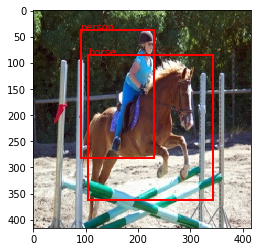

In [738]:
fig = plt.figure(figsize=(16, 9))
f, ax = plt.subplots(1, 1)
ax.imshow(img[0])
# 一張照片上可能有多個物件，因此要迴圈處理    
for idx in range(len(best_bboxes)):
    obj = best_bboxes[idx]
    
    _x = obj[0]
    _y = obj[1]
    _w = (obj[2]) - (obj[0])
    _h = (obj[3]) - (obj[1])
    _label = obj[5]

    # 畫方框
    rect = patches.Rectangle((_x, _y), 
                             _w, 
                             _h, 
                             linewidth=2, 
                             facecolor='none', 
                             edgecolor='red')                
    ax.add_patch(rect)
    ax.text(x=_x, y=_y, s=VOC_LABEL_NAME[_label], color='red')    
    print(f'x= {_x}, y= {_y}, w= {_w}, h= {_h}, label={VOC_LABEL_NAME[_label]}')        

plt.show()

很明顯，這狀況超乎預期的糟糕，不過雖然如此，我們也終於是把nms也寫完了，NMS有很多種，這部份可以參考[知乎](https://zhuanlan.zhihu.com/p/89426063)，現在最重要的事情就是回頭重新訓練模型 

整個YOLOv3也差不多就是這樣子，從輸入一張416x416的照片輸入，到三個尺度的anchor box的資訊輸出，我們發現到卷積神經網路的輸出有這麼讓人驚豔的可塑性。下一步，我們要來嚐試優化網路，讓網路的預測可以更符合我們的需求。

## 附錄

下面給出np.multiply.reduce的範例，這邊做的就是計算面積

In [739]:
_anchor = np.arange(1, 5).reshape((1, 4))
_anchor, _anchor.shape

(array([[1, 2, 3, 4]]), (1, 4))

下面做的是沿著最後一個軸做相乘，所以3x4=12、1x2=2

In [740]:
np.multiply.reduce(_anchor[: , 2:4], axis=-1), np.multiply.reduce(_anchor[: , 0:2], axis=-1)

(array([12]), array([2]))

下面做的是左上x、右下x座標相減得高，然後左上y、右下y座標相減得寬，然後沿著最後一個軸做相乘，因此得到(3-1) \* (4-2) = 4，再開根號就得到2

In [741]:
np.sqrt(np.multiply.reduce(_anchor[: , 2: 4] - _anchor[:, 0: 2], axis=-1))

array([2.])